In [1]:
import numpy as np
import keras
from keras import layers
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from matplotlib import colors
import math
# Load the data and split it between train and test sets
(x_train, y_train_digits), (x_test, y_test_digits) = keras.datasets.mnist.load_data()
print(np.shape(x_train), np.shape(y_train_digits), "|||", np.shape(x_test), np.shape(y_test_digits))


(60000, 28, 28) (60000,) ||| (10000, 28, 28) (10000,)


# Import MNIST database and change its shape

In [2]:
size_input = 784
size_hidden = 20
size_output = 10

In [3]:
x_train = x_train.reshape(np.size(x_train,0),-1)/255.0
x_test = x_test.reshape(np.size(x_test,0),-1)/255.0


In [4]:
y_train = keras.utils.to_categorical(y_train_digits, size_output)
y_test = keras.utils.to_categorical(y_test_digits, size_output)

In [5]:
print(np.shape(x_train), np.shape(y_train), "|||", np.shape(x_test), np.shape(y_test))

(60000, 784) (60000, 10) ||| (10000, 784) (10000, 10)


# FNN training

## Create the network

In [6]:
def func_initialize_network(n_inputs, n_hidden, n_outputs):
  network = {'W1' : np.random.randn(n_inputs,n_hidden),
             'W2' : np.random.randn(n_hidden,n_outputs),
             'A1' : 0,
             'A2' : 0,
             'Z1' : 0,
             'Z2' : 0}

  return network

## Activation functions and their derivatives

In [7]:
def func_sigmoid (x) : # Sigmoid function
  return 1/(1+np.exp(-x))

In [8]:
def func_sigmoid_derivative (x) : # Its derivative
  sigm = func_sigmoid (x)
  return sigm*(1-sigm)

In [9]:
def func_softmax (x) : # Softmax function
  return np.exp(x)/np.sum(np.exp(x),axis=1,keepdims=True)

In [10]:
def func_softmax_derivative (x) : # Its derivative
  I = np.eye(x.shape[0])
  soft_x = func_softmax(x)
  return soft_x * (I - soft_x.T)

## Noise realization

In [11]:
#uncorr (uncommon)
#noise_training=np.random.normal(0,1,(60000,size_hidden))
#noise_testing=np.random.normal(0,1,(10000,size_hidden))
#corr (common)
noise_training=np.dot(np.random.normal(0,1,(60000,1)), np.ones((1,size_hidden)))
noise_testing=np.dot(np.random.normal(0,1,(10000,1)), np.ones((1,size_hidden)))
print(np.shape(noise_training), np.shape(noise_testing))


(60000, 20) (10000, 20)


## Forward propagation

In [12]:
def forward_propagation(input_data, my_net_old, noise):
  my_net = dict(my_net_old)
  D=0.5
  my_net['Z1'] = np.dot(input_data, my_net['W1'])
  my_net['A1'] = func_sigmoid(my_net['Z1'])*(1+np.sqrt(2*D)*noise)   #+np.sqrt(2*D)*noise   #*(1+np.sqrt(2*D)*noise)      #   +np.sqrt(2*D)*noise #        + noise to hidden layer
  my_net['Z2'] = np.dot(my_net['A1'], my_net['W2'])            #*(1+np.sqrt(2*D)*noise)                                                                + noise to output layer
  my_net['A2'] = func_softmax(my_net['Z2'])
  output_data = np.array(my_net['A2'])
  return output_data, my_net

## Loss functions

In [13]:
def func_loss_function_sigmoid(y_true, y_predicted) :
  L = np.mean(-y_true*np.log(y_predicted) - (1-y_true)*np.log(1-y_predicted), axis=0)
  return L

In [14]:
def func_loss_function_softmax(y_true, y_predicted) :
  L = -np.mean(y_true * np.log(y_predicted + 1e-8))
  return L

## Accuracy

In [15]:
def calculate_accuracy(y_true, y_predicted) : # Percentage accuracy
  acc = np.mean(np.argmax(y_true, axis=1) == np.argmax(y_predicted, axis=1))*100
  return acc

In [16]:
def save_accuracy_loss(y_true, y_predicted, acc_list=[], loss_list=[]) :
  loss_val = func_loss_function_softmax(y_true, y_predicted)
  acc_val = calculate_accuracy(y_true, y_predicted)

  acc_list.append(acc_val)
  loss_list.append(loss_val)

  return acc_list, loss_list

## Back propagation

In [17]:
def backward_propagation(input_data, target_output, my_net, learning_rate):
  N = np.size(target_output,0)

  dZ = my_net['A2'] - target_output
  dW = np.dot(my_net['A1'].T, dZ) / N
  dW2 = np.array(dW)
  dAPrev = dZ.dot(my_net['W2'].T)
  dZ = dAPrev * func_sigmoid_derivative(my_net['Z1'])

  dW = np.dot(input_data.T, dZ) / N  # my_net['A0']=input_data
  dW1 = np.array(dW)
  #dAPrev = dZ.dot(my_net['W1'].T)
  #db = np.sum(dZ, axis=1, keepdims=True) / N

  # Update the connection matrices
  my_net['W2'] = my_net['W2'] - learning_rate * dW2
  my_net['W1'] = my_net['W1'] - learning_rate * dW1

  return my_net

## Training

In [23]:
learning_rate=10

my_net = func_initialize_network(size_input, size_hidden, size_output)

#If you need to load the initial values of the connection matrices :
#my_net['W1'] = np.loadtxt("ic_v4_W1.dat") # the shape should be  784 х size_hidden
#my_net['W2'] = np.loadtxt("ic_v4_W2.dat") # the shape should be  size_hidden x 10

# Otherwise get new random initial conditions :
initial_W1 = my_net['W1']
initial_W2 = my_net['W2']

acc_list_train = []
loss_list_train = []

acc_list_test = []
loss_list_test = []

#N = np.size(x_train,0)

for epo in range(400) :    
  # Training set
  y_predicted_train, my_net = forward_propagation(x_train, my_net, noise_training)
  acc_list_train, loss_list_train = save_accuracy_loss(y_train, y_predicted_train, acc_list_train, loss_list_train)
  # Testing set
  y_predicted_test, my_net_temp = forward_propagation(x_test, my_net, noise_testing)
  acc_list_test, loss_list_test = save_accuracy_loss(y_test, y_predicted_test, acc_list_test, loss_list_test)
  print(str(epo)+" | acc.tr. = "+('%.2f' % acc_list_train[-1])+"% | loss.tr. = "+('%.2f' % loss_list_train[-1])+" | acc.te. = "+('%.2f' % acc_list_test[-1])+"% | loss.te. = "+('%.2f' % loss_list_test[-1]))
  # Backpropagation
  my_net = backward_propagation(x_train, y_train, my_net, learning_rate)

y_predicted_train, my_net_temp = forward_propagation(x_train, my_net, noise_training)
acc_list_train, loss_list_train = save_accuracy_loss(y_train, y_predicted_train, acc_list_train, loss_list_train)
y_predicted_test, my_net_temp = forward_propagation(x_test, my_net, noise_testing)
acc_list_test, loss_list_test = save_accuracy_loss(y_test, y_predicted_test, acc_list_test, loss_list_test)
print("\nFINAL "+str(epo+1)+" ::: acc.tr. = "+('%.2f' % acc_list_train[-1])+"% | loss.tr. = "+('%.2f' % loss_list_train[-1])+" | acc.te. = "+('%.2f' % acc_list_test[-1])+"% | loss.te. = "+('%.2f' % loss_list_test[-1]))

# Generate of array with accuracies
to_file = np.zeros((len(acc_list_train),5))
to_file[:,0] = list(range(len(acc_list_train)))
to_file[:,1] = acc_list_train
to_file[:,2] = acc_list_test
to_file[:,3] = loss_list_train
to_file[:,4] = loss_list_test

# And save it
np.savetxt("examples/net01_training_process.dat",to_file)

# Save initial conditions for this training
np.savetxt("examples/net01_ic_W1.dat",initial_W1)
np.savetxt("examples/net01_ic_W2.dat",initial_W1)

# Save new matrices of trained net
W1 = my_net['W1']
W2 = my_net['W2']
np.savetxt("examples/net01_trained_W1.dat",W1)
np.savetxt("examples/net01_trained_W2.dat",W2)

0 | acc.tr. = 10.04% | loss.tr. = 0.52 | acc.te. = 9.77% | loss.te. = 0.53
1 | acc.tr. = 18.56% | loss.tr. = 0.68 | acc.te. = 18.05% | loss.te. = 0.69
2 | acc.tr. = 14.61% | loss.tr. = 0.79 | acc.te. = 14.86% | loss.te. = 0.79
3 | acc.tr. = 26.00% | loss.tr. = 0.65 | acc.te. = 26.13% | loss.te. = 0.65
4 | acc.tr. = 24.42% | loss.tr. = 0.60 | acc.te. = 24.58% | loss.te. = 0.61
5 | acc.tr. = 26.64% | loss.tr. = 0.33 | acc.te. = 26.48% | loss.te. = 0.32
6 | acc.tr. = 38.12% | loss.tr. = 0.23 | acc.te. = 38.07% | loss.te. = 0.23
7 | acc.tr. = 45.12% | loss.tr. = 0.19 | acc.te. = 45.17% | loss.te. = 0.19
8 | acc.tr. = 49.69% | loss.tr. = 0.18 | acc.te. = 49.56% | loss.te. = 0.18
9 | acc.tr. = 51.81% | loss.tr. = 0.18 | acc.te. = 52.02% | loss.te. = 0.18
10 | acc.tr. = 53.53% | loss.tr. = 0.18 | acc.te. = 53.95% | loss.te. = 0.18
11 | acc.tr. = 54.98% | loss.tr. = 0.17 | acc.te. = 55.40% | loss.te. = 0.17
12 | acc.tr. = 56.12% | loss.tr. = 0.17 | acc.te. = 56.44% | loss.te. = 0.17
13 | acc.t

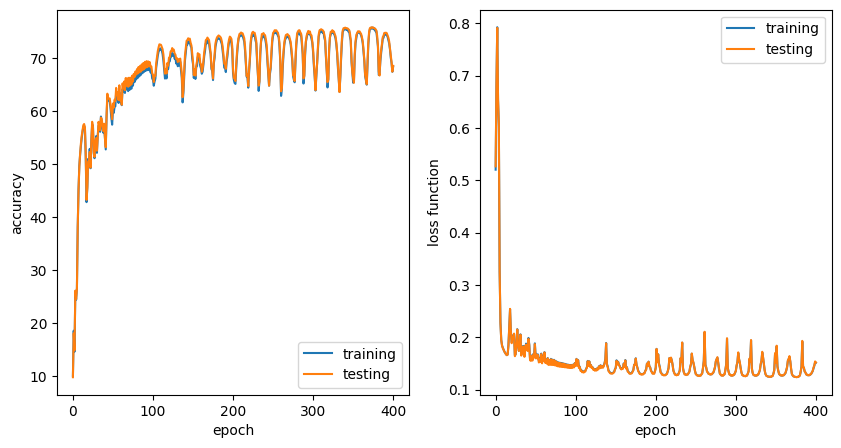

In [24]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax1.plot(acc_list_train, label="training")
ax1.plot(acc_list_test, label="testing")
ax1.set_xlabel("epoch")

ax1.set_ylabel("accuracy")
ax1.legend()

ax1 = fig.add_subplot(122)
ax1.plot(loss_list_train, label="training")
ax1.plot(loss_list_test, label="testing")
ax1.set_xlabel("epoch")
ax1.set_ylabel("loss function")
ax1.legend()


# Import trained network in order to introduce the noise

In [31]:
    
y_train_digit = np.argmax(y_train, axis=1)
y_test_digit = np.argmax(y_test, axis=1)

#x_hidd = sigmoid(np.dot(x_train,W1))
# np.shape(np.dot(x_hidd,W2))
W1=np.loadtxt("examples/net01_trained_W1.dat")
W2=np.loadtxt("examples/net01_trained_W2.dat")
N_input_neurons=np.dot(x_train,W1)
hidden_layer=func_sigmoid(np.dot(x_train,W1))

# Calculate the accuracy on training dataset
with open('examples/net01_added_noise_training_data.txt', 'w') as f:
    for D in np.arange (0,1,0.005):
        hidden_noise_layer=hidden_layer*(1+np.sqrt(2*D)*noise_training)   
        N_output_neurons= np.dot(hidden_noise_layer,W2)
        ANN_resp = np.argmax(N_output_neurons, axis=1)
        Accuracy_noise_train=np.sum(y_train_digit==ANN_resp)/len(ANN_resp)
        f.write(f'{D} {Accuracy_noise_train}\n')
print(f'Accuracy for training data: {Accuracy_noise_train}')

N_input_neurons=np.dot(x_test,W1)
hidden_layer=func_sigmoid(np.dot(x_test,W1))

# Calculate the accuracy on testing dataset
with open('examples/net01_added_noise_testing_data.txt', 'w') as f:
    for D in np.arange (0,1,0.005):  # Change the noise intensity in the loop
        hidden_noise_layer2=hidden_layer*(1+np.sqrt(2*D)*noise_testing)
        N_output_neurons2= np.dot(hidden_noise_layer2,W2)
        ANN_resp2 = np.argmax(N_output_neurons2, axis=1)
        Accuracy_noise_test=np.sum(y_test_digit==ANN_resp2)/len(ANN_resp2)
        f.write(f'{D} {Accuracy_noise_test}\n')
print(f'Accuracy for testing data: {Accuracy_noise_test}')


Accuracy for training data: 0.6199333333333333
Accuracy for testing data: 0.6238


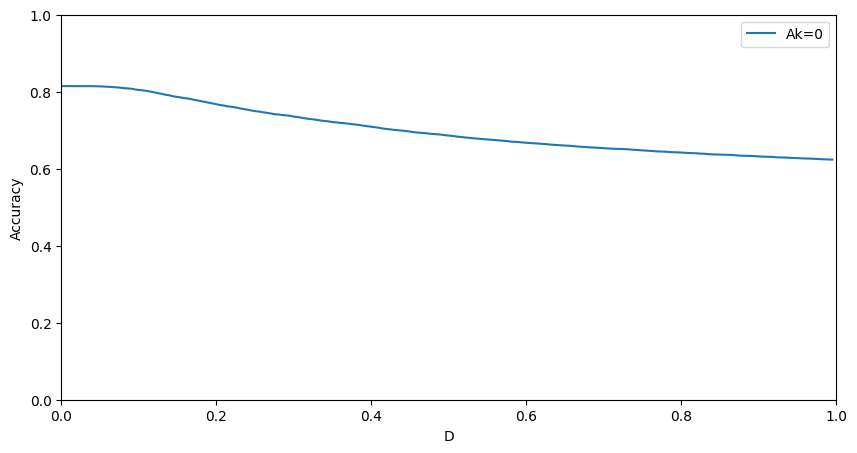

In [33]:
file1 = np.loadtxt('examples/net01_added_noise_testing_data.txt')
#file2 = ...
#file3 = ...
#file4 = ...
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)
ax1.plot(file1[:, 0], file1[:, 1], label='Ak=0')
#ax1.plot(file2[:, 0], file2[:, 1], label='Ak=0.001')
#ax1.plot(file3[:, 0], file3[:, 1], label='Ak=0.1')
#ax1.plot(file4[:, 0], file4[:, 1], label='Ak=0.5')

ax1.set_xlabel('D')
ax1.set_ylabel('Accuracy')
ax1.legend()
ax1.set_xlim([0,1])
ax1.set_ylim([0,1])
fig.savefig('figure.pdf')